In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# use inspector to explore the database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# for table = measurement, use inspector to print column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# for table = station, use inspector to print column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the Measurement table
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [14]:
# Calculate the date of the last 12 months from the most recent date in the Measurement table
date_select = datetime.strptime(recent_date, '%Y-%m-%d')
delta = timedelta(days=365)
year_ago_date = date_select - delta
year_ago_date = (date_select - delta).strftime('%Y-%m-%d')
print(year_ago_date)

2016-08-23


In [15]:
# Query for last 12 months of precipitation data
prcp_12 = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= year_ago_date).filter(Measurement.date <= recent_date).order_by(Measurement.date).all()

#Display
prcp_12

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [16]:
# load the query into DataFrame
prcp_12_df = pd.DataFrame(prcp_12, columns=['date', 'precipitation'])

# set index to date and sort by date 
prcp_12_df.set_index('date').sort_values(by=['date'])                    

# display
prcp_12_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [17]:
# print summary statistics for the precipitation data
prcp_12_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


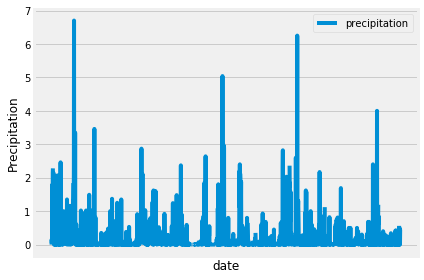

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_12_df.plot(x_compat=True)

# label x and y axis
plt.ylabel("Precipitation")
plt.xlabel("date")

# remove xticks label
plt.xticks([])

plt.tight_layout()
plt.savefig("Images/Precipitation.png")
plt.show()

In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
station_count

9

In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### What are the most active stations? Station USC00519281

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# query the station with the highest number of temperature observations
station_max_obs = session.query(Measurement.station, func.max(Measurement.tobs)).all()[0][0]
station_max_obs

'USC00519397'

In [26]:
# Query the last 12 months of temperature observation data for this station
results = session.query(Measurement.tobs).\
              filter(Measurement.station == station_max_obs).\
              filter(Measurement.date >= year_ago_date).filter(Measurement.date <= recent_date).order_by(Measurement.date).all()

In [27]:
# load the query into data frame
station_max_obs_df = pd.DataFrame(results)

# display
station_max_obs_df.head()

,tobs
0,81.0
1,79.0
2,80.0
3,79.0
4,77.0


<function matplotlib.pyplot.show(*args, **kw)>

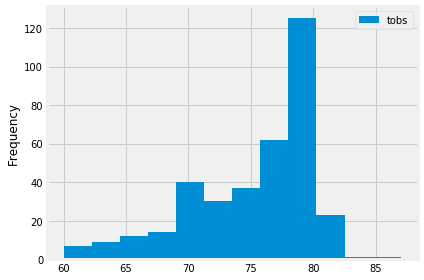

In [28]:
# Plot the results as a histogram
station_max_obs_df.plot.hist(bins=12)
plt.tight_layout()
plt.savefig("Images/StationHistogram.png")
plt.show

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
           filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2017, 2, 28)
trip_end = dt.date(2017, 3, 5)

# Get dates for previous year
start_date = trip_start - dt.timedelta(days=365)
end_date = trip_end - dt.timedelta(days=365)

trip_temps = calc_temps(start_date, end_date)
trip_temps


[(62.0, 69.65789473684211, 79.0)]

C:\Users\jarrett\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


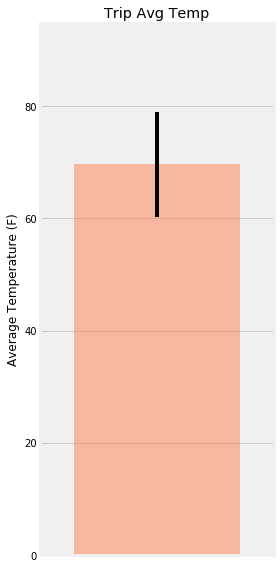

In [31]:
# plotting the data as bar chart
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
avg_temp = trip_temps[0][1]
xpos = 1

# use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = trip_temps[0][2] - trip_temps[0][1]

bar = ax.bar(xpos, avg_temp, yerr=error, alpha=0.5, color='coral', align='center')
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Average Temperature (F)")
ax.margins(.2, .2)
fig.tight_layout()
fig.savefig("Images/Temperature.png")
fig.show()

In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start = '2017-02-28'
trip_end = '2017-03-05'

rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print (rainfall)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.720000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.07), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.7399999999999998), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.32), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.1600000000000001)]


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-14'

# use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()

# list comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]

# find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# query the daily normals that calculate the averages for tmin, tmax, and tavg for a specific month and day of your trip
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
daily_normals = session.query(*sel).\
                filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                group_by(func.strftime("%m-%d", Measurement.date)).all()

print("Aggregate Daily Normals for 01-01 to 01-14")
daily_normals


Aggregate Daily Normals for 01-01 to 01-14


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0)]

In [35]:
# load into data frame
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# set index to date
daily_normals_df.set_index('date',inplace=True)

# display
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


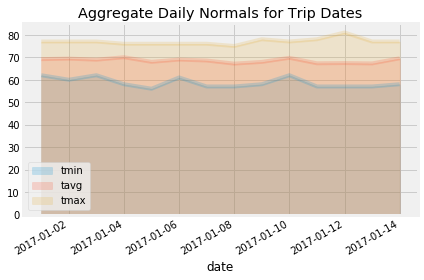

In [36]:
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()